In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast

from xgboost import XGBRegressor

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [81]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [82]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [83]:
df_brl.head()

,ds,y,unique_id
0,2020-01-01,73.428636,ACUCAR_SANTOS
1,2020-02-01,81.636111,ACUCAR_SANTOS
2,2020-03-01,79.906364,ACUCAR_SANTOS
3,2020-04-01,77.113500,ACUCAR_SANTOS
4,2020-05-01,84.638500,ACUCAR_SANTOS


In [84]:
train, val, test = split_series(df_brl)

Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


In [85]:
model = XGBRegressor(
    n_estimators=50, 
    learning_rate=0.03125,
    reg_alpha=0, 
    reg_lambda=0.01,
    max_depth=6, 
    objective='reg:squarederror'
)

fcst = MLForecast(
    models={'xgb': model},
    lags=[1, 2],
    freq='MS'
)

In [86]:
# start tunning here if needed eventually

In [87]:
full_train = pd.concat([train, val])

In [88]:
fcst.fit(full_train)

MLForecast(models=[xgb], freq=MS, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [89]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [90]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [91]:
evaluator = MetricEvaluator()

In [92]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['xgb'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS   xgb              20   10.977421  0.074923    159.111132   
1        ACUCAR_SP   xgb             100   17.207655  0.209098    353.869527   
2          ALGODAO   xgb             205   25.584448  0.066349   1532.162754   
3            ARROZ   xgb             277   28.462888  0.594897    833.811850   
4     CAFE_ARABICA   xgb             381  130.697156  0.164262  71492.168314   
5     CAFE_ROBUSTA   xgb             468   47.752608  0.078786  22042.215276   
6            MILHO   xgb             543   31.414465  0.759167    998.613290   
7      SOJA_PARANA   xgb             644   25.716216  0.352366    692.715845   
8   SOJA_PARANAGUA   xgb             714   15.356953  0.176516    242.913610   
9     TRIGO_PARANA   xgb             791  236.524954  0.244186  81437.881948   
10        TRIGO_RS   xgb             868  188.724939  0.210508  55997.990007   

          RMSE        R2  
0    12.6139

In [93]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                        MAPE                  \
          mean      std      min      max   median    mean     std     min   
Model                                                                        
xgb    68.9472  78.9922  10.9774  236.525  28.4629  0.2665  0.2226  0.0663   

                              MSE                                              \
          max  median        mean         std       min         max    median   
Model                                                                           
xgb    0.7592  0.2091  21434.8594  32117.9655  159.1111  81437.8819  998.6133   

           RMSE                                            R2                  \
           mean       std      min       max   median    mean     std     min   
Model                                                                           
xgb    100.9826  111.1805  12.6139  285.3732  31.6008 -0.5534  1.7917 -5.4742   

        

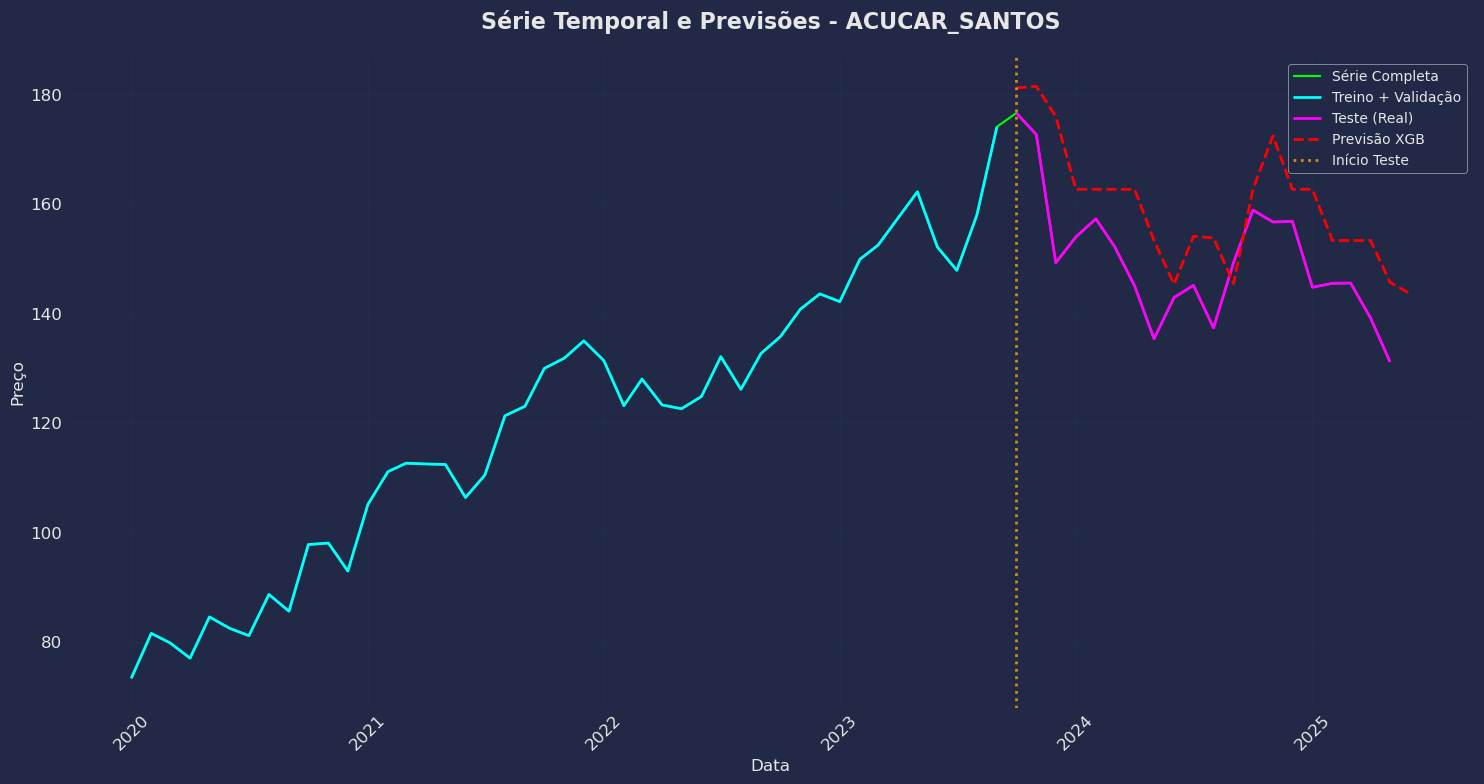

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


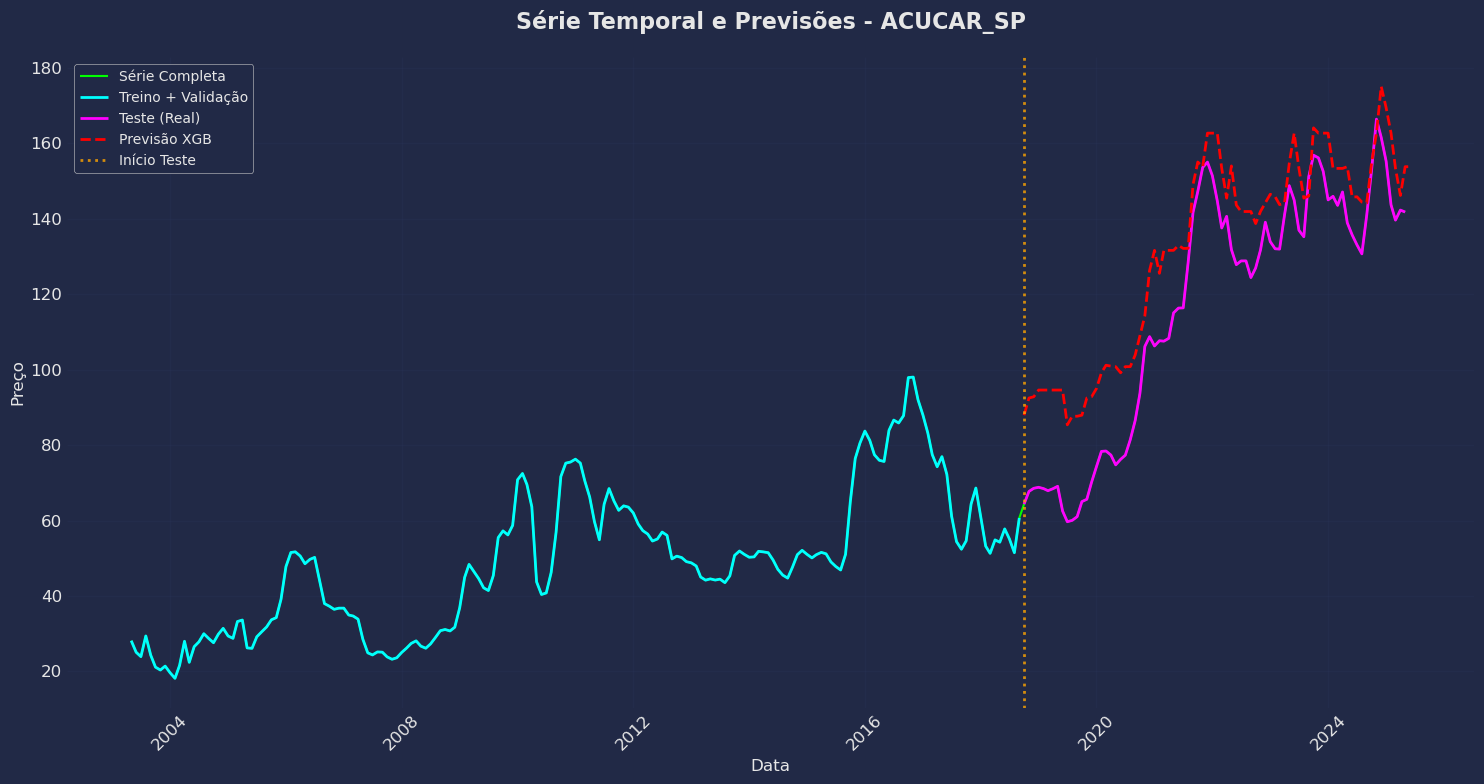

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


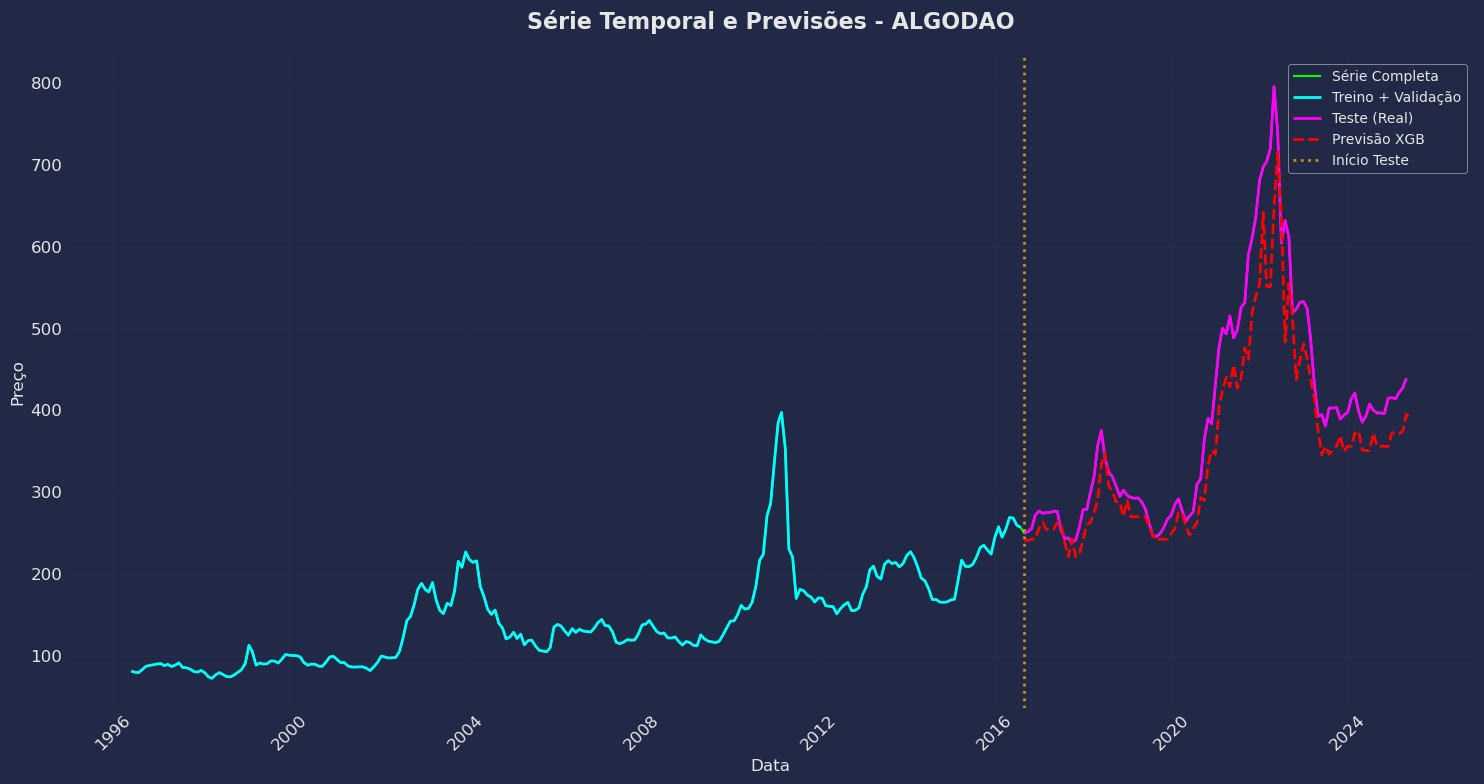

Gráfico exibido para: ALGODAO
--------------------------------------------------


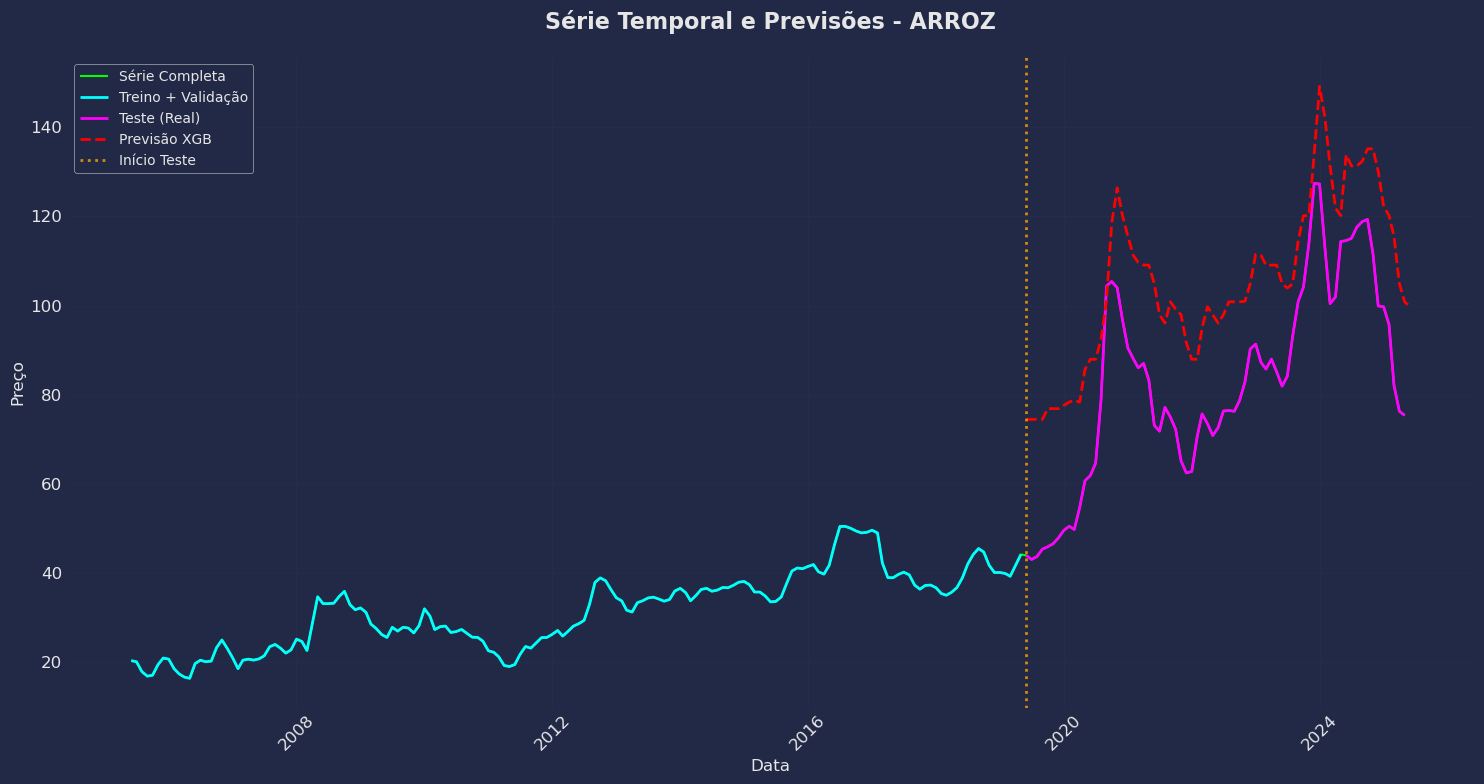

Gráfico exibido para: ARROZ
--------------------------------------------------


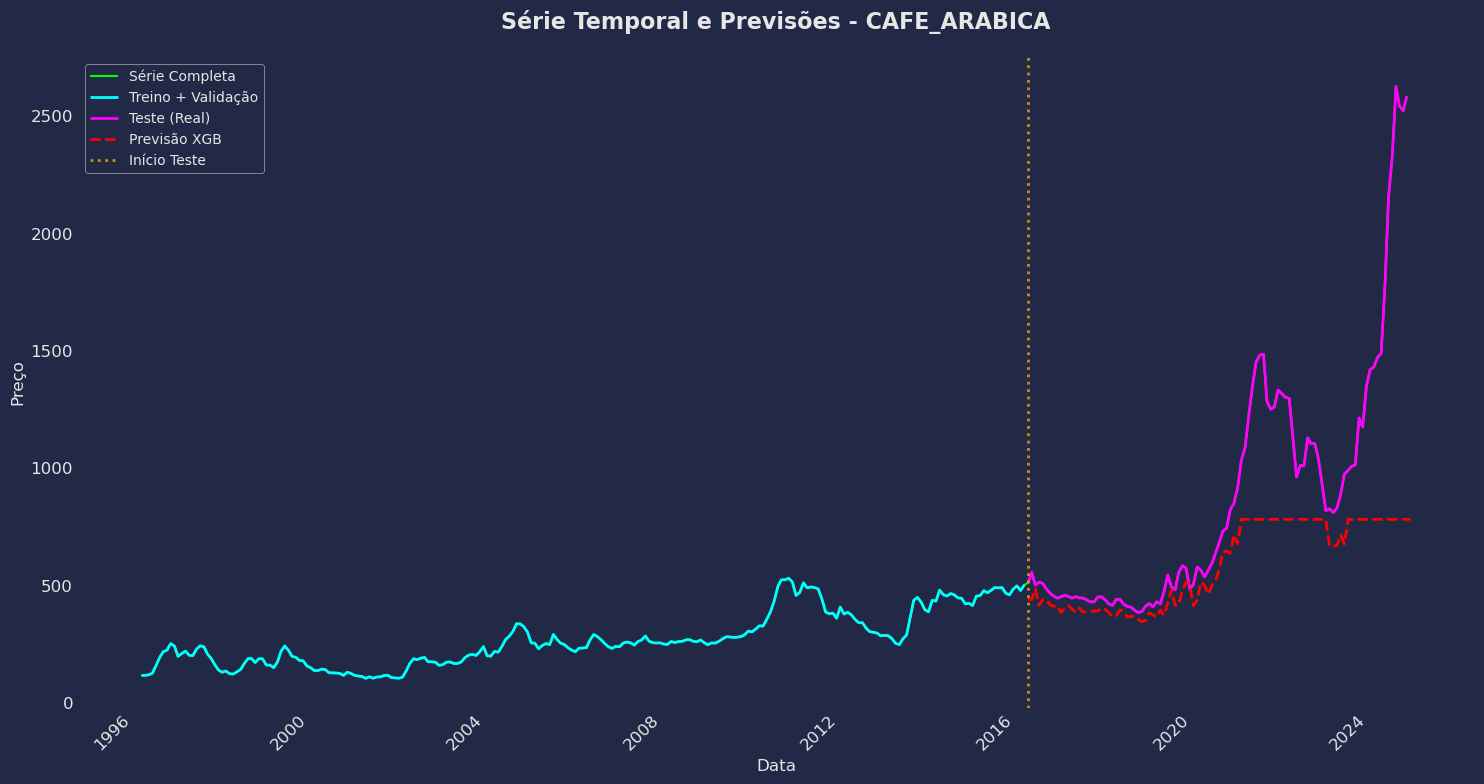

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


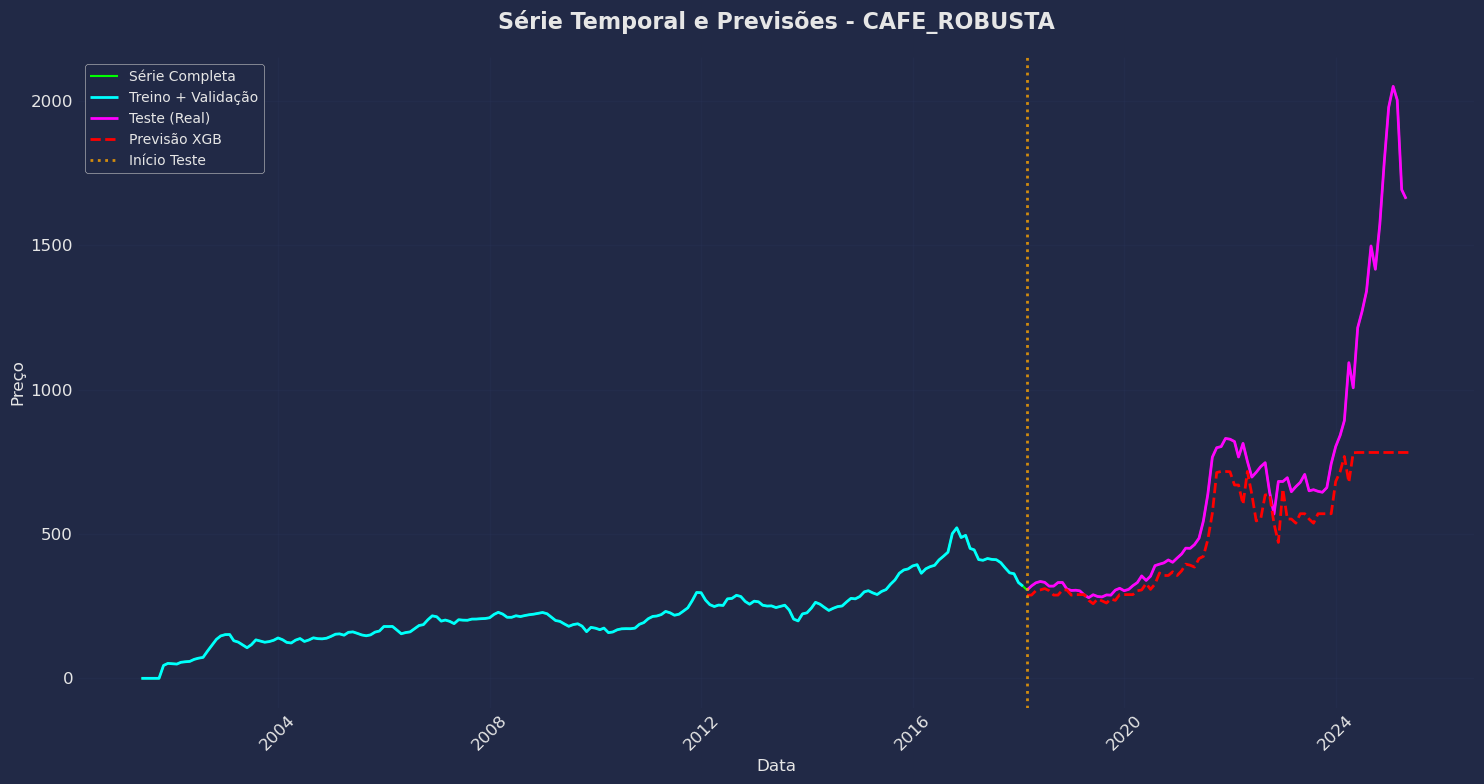

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


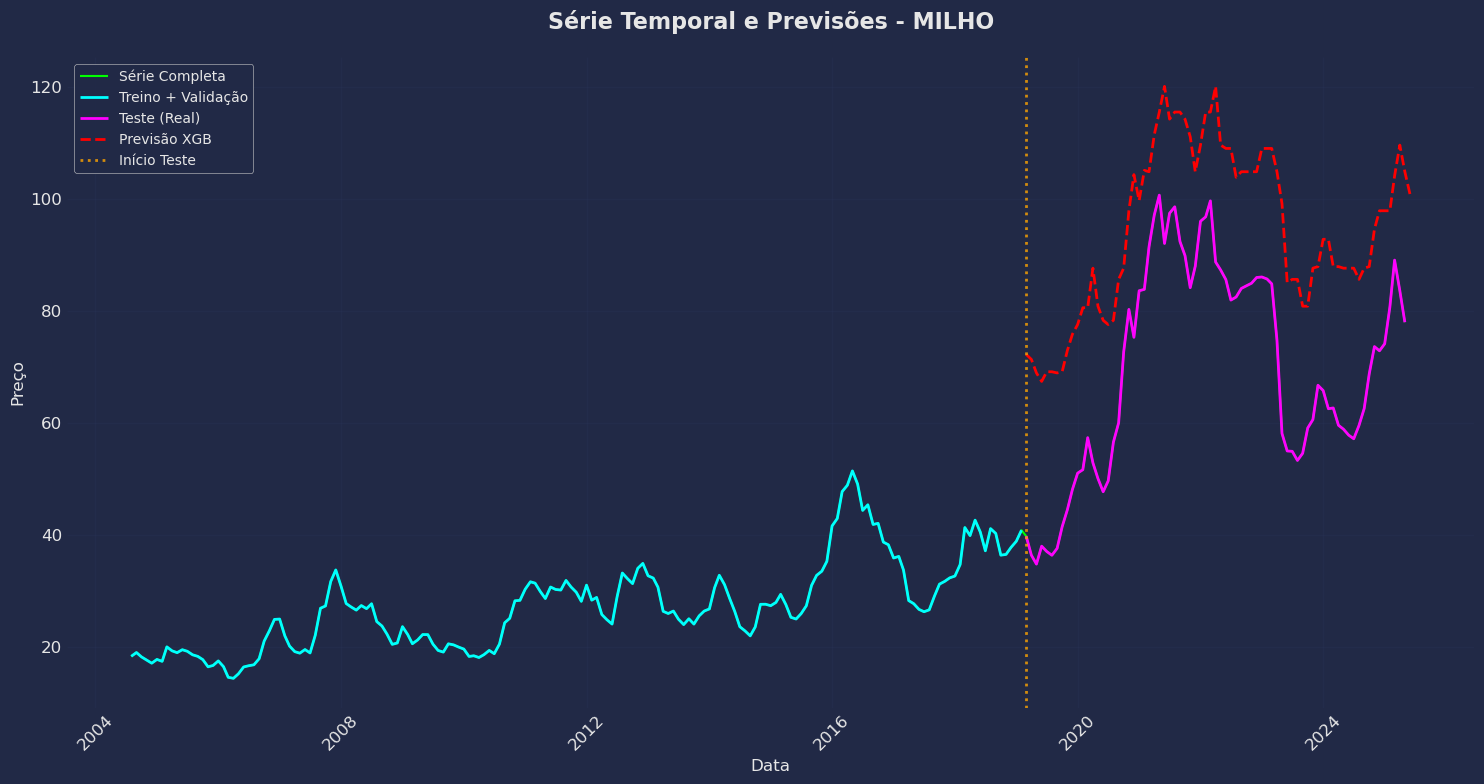

Gráfico exibido para: MILHO
--------------------------------------------------


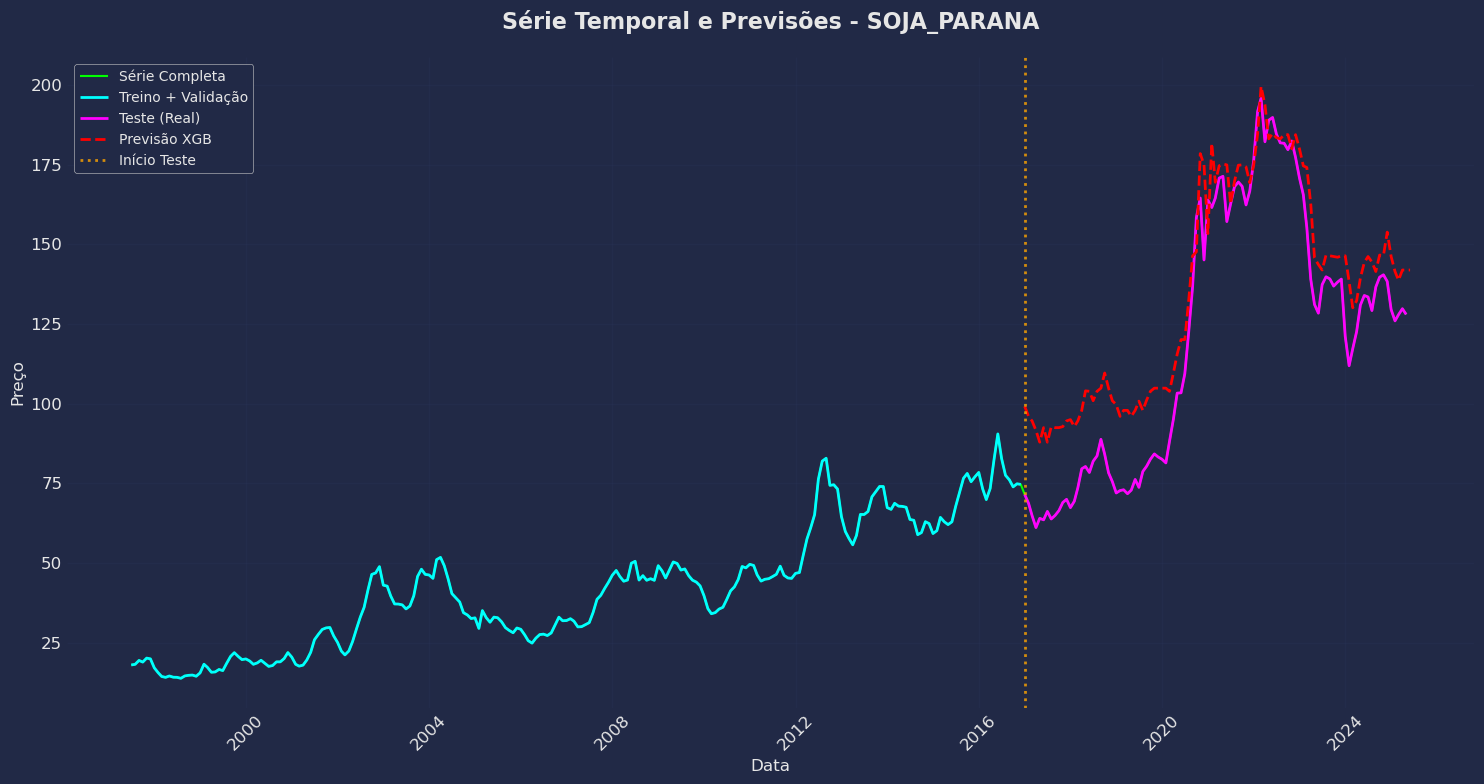

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


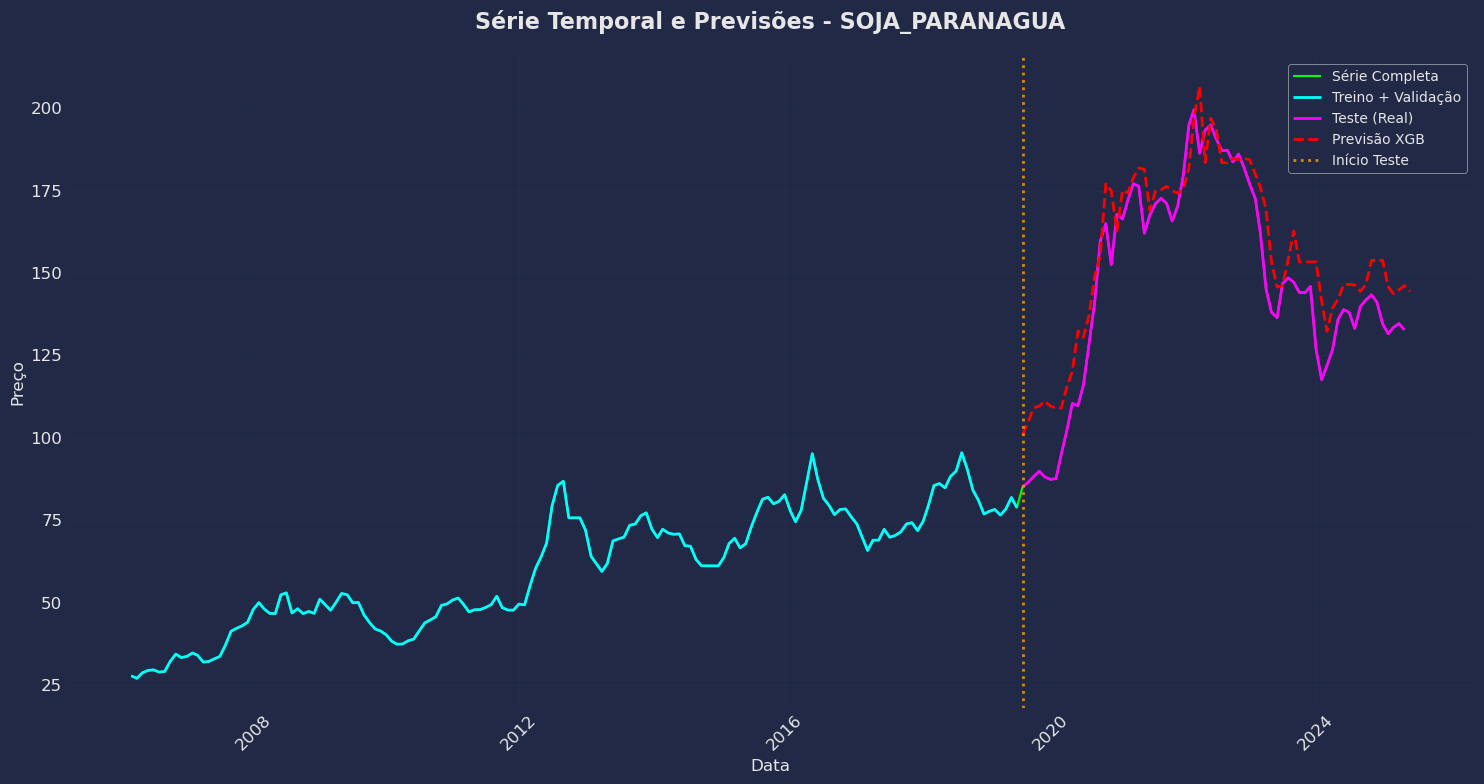

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


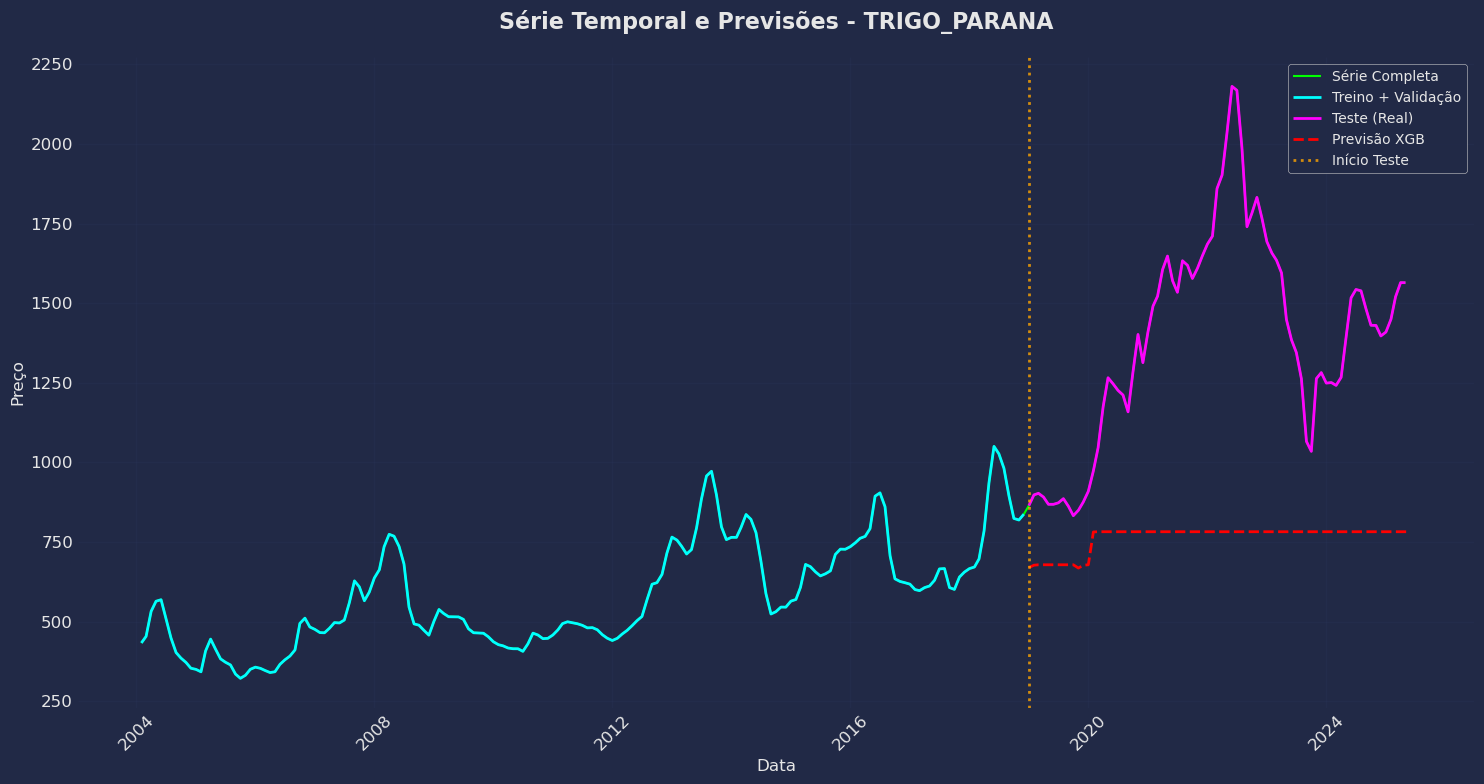

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


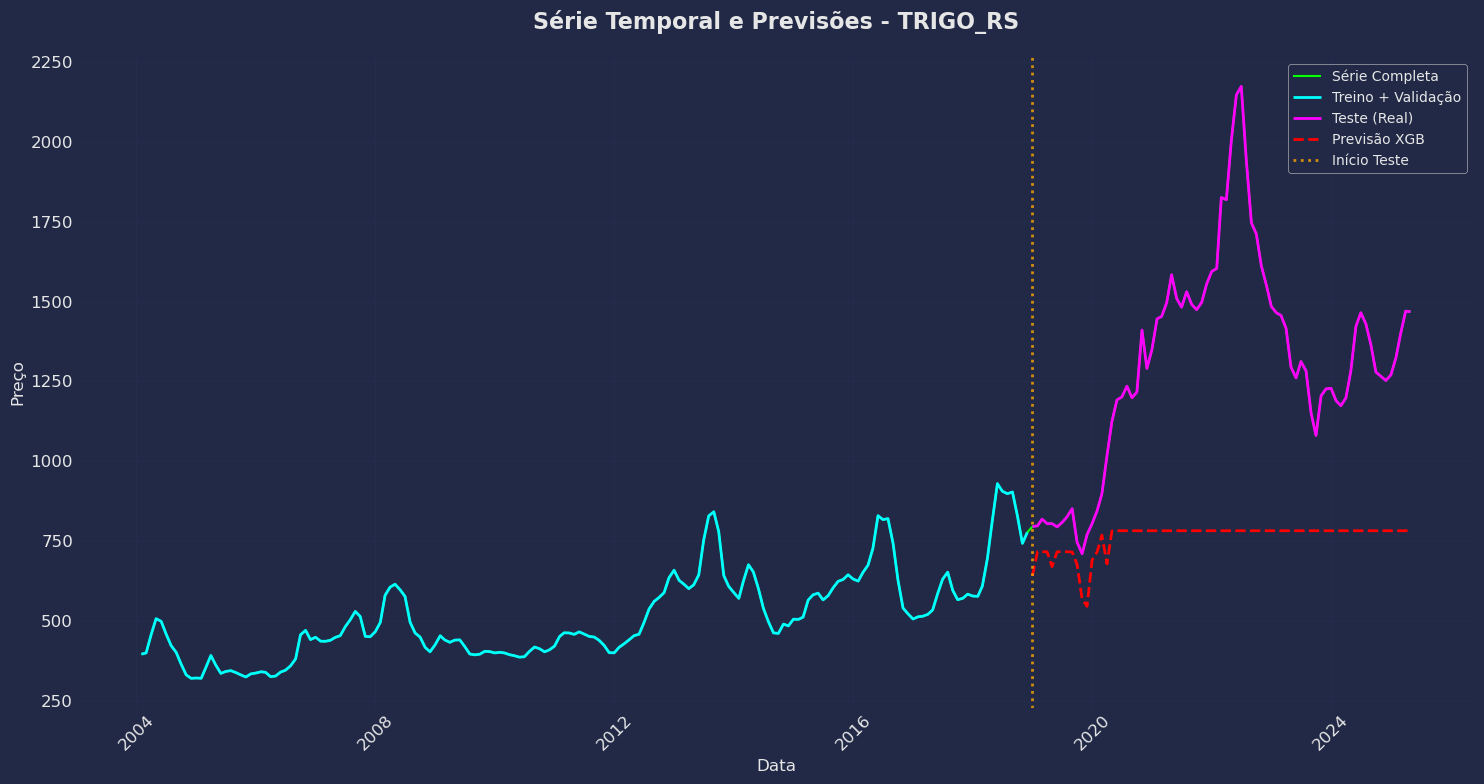

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [97]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['xgb'], 
                color='red', linewidth=2, linestyle='--', label='Previsão XGB')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)